In [1]:
import sys
sys.path.append("../src")

import networkx as nx
from utils import parse_event, apply_time_decay
import json
from datetime import datetime

In [2]:
with open("../data/mock_tweets.json", "r") as f:
    events = json.load(f)

In [3]:
G = nx.DiGraph()
for event in sorted(events, key=lambda x: x["timestamp"]):
    timestamp = datetime.fromisoformat(event["timestamp"])
    edge_type, source, target, label = parse_event(event)
    
    for node in [source, target]:
        if node and not G.has_node(node):
            G.add_node(node, type="user" if node.startswith("u") else "tweet" if node.startswith("t") else "hashtag")

    G.add_edge(source, target, label=label, timestamp=timestamp)
    G[source][target]["weight"] = apply_time_decay(timestamp, reference_time=events[0]["timestamp"])


In [4]:
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
list(G.edges(data=True))[:3]  # Show a few sample edges


Nodes: 4
Edges: 3


[('u001',
  't001',
  {'label': 'posted',
   'timestamp': datetime.datetime(2025, 6, 1, 12, 0),
   'weight': 1.0}),
 ('u002',
  't001',
  {'label': 'retweeted',
   'timestamp': datetime.datetime(2025, 6, 1, 12, 5),
   'weight': 0.9439}),
 ('u003',
  't001',
  {'label': 'liked',
   'timestamp': datetime.datetime(2025, 6, 1, 12, 10),
   'weight': 0.8909})]

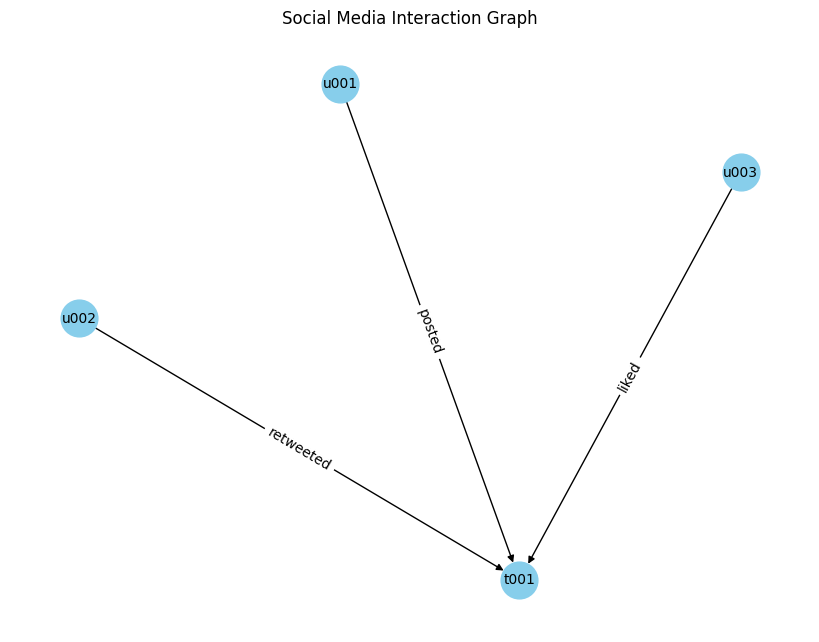

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)})
plt.title("Social Media Interaction Graph")
plt.show()

In [6]:
import time
from IPython.display import clear_output

G = nx.DiGraph()
reference_time = datetime.fromisoformat(events[0]["timestamp"])

for i, event in enumerate(sorted(events, key=lambda x: x["timestamp"])):
    timestamp = datetime.fromisoformat(event["timestamp"])
    _, source, target, label = parse_event(event)

    for node in [source, target]:
        if node and not G.has_node(node):
            G.add_node(node, type="user" if node.startswith("u") else "tweet" if node.startswith("t") else "hashtag")

    G.add_edge(source, target, label=label, timestamp=timestamp)
    G[source][target]["weight"] = apply_time_decay(timestamp, reference_time)

    clear_output(wait=True)
    print(f"Step {i+1}/{len(events)} → {source} → {target} [{label}]")
    print(f"  Weight: {G[source][target]['weight']:.4f}")
    print(f"  Total nodes: {G.number_of_nodes()} | Total edges: {G.number_of_edges()}")
    time.sleep(1)

Step 3/3 → u003 → t001 [liked]
  Weight: 0.8909
  Total nodes: 4 | Total edges: 3


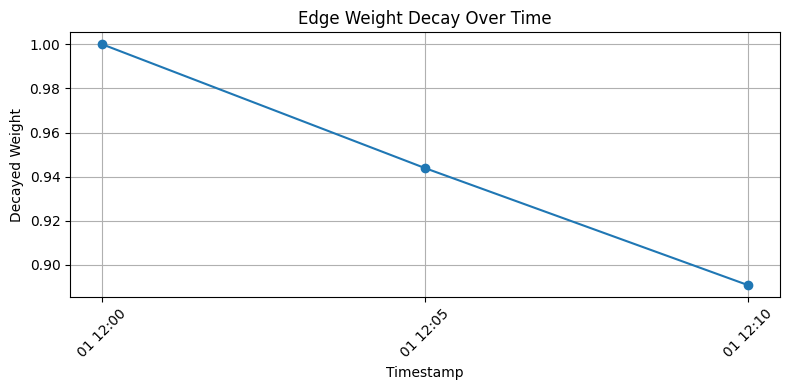

In [7]:
import pandas as pd
timestamps = []
weights = []

for u, v, d in G.edges(data=True):
    timestamps.append(d["timestamp"])
    weights.append(d["weight"])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, weights, marker='o')
plt.xticks(rotation=45)
plt.ylabel("Decayed Weight")
plt.xlabel("Timestamp")
plt.title("Edge Weight Decay Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
assert not any(u == v for u, v in G.edges()), "ERROR: Graph has self-loops!"
assert all(0 <= d['weight'] <= 1 for _, _, d in G.edges(data=True)), "ERROR: Edge weights out of range"
assert all('type' in data for _, data in G.nodes(data=True)), "ERROR: Node type missing"
print("SUCCESS: Graph passed all integrity checks!")

SUCCESS: Graph passed all integrity checks!


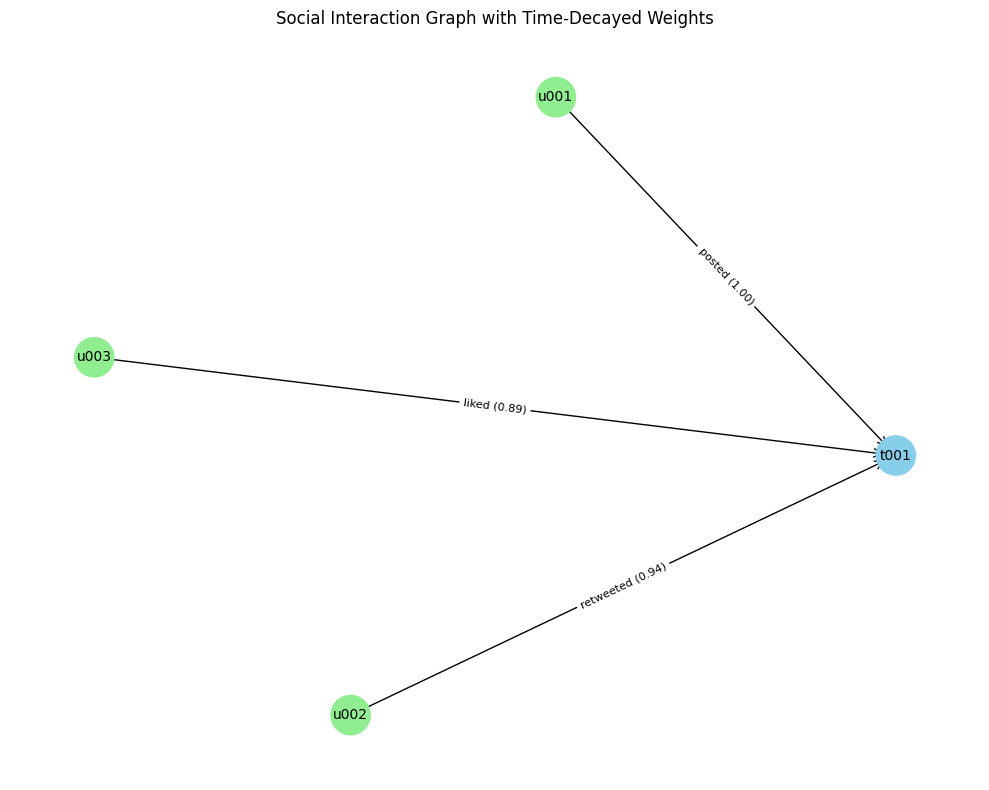

In [9]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes by type
node_types = nx.get_node_attributes(G, "type")
colors = {"user": "lightgreen", "tweet": "skyblue", "hashtag": "orange"}
node_colours = [colors.get(node_types[n], "grey") for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colours, node_size=800)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15)

# Label edges with type and weight
edge_labels = {
    (u, v): f"{d['label']} ({d['weight']:.2f})"
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Social Interaction Graph with Time-Decayed Weights")
plt.axis("off")
plt.tight_layout()
plt.show()